In [2]:
from backtest import do_simulation, perform_closing_strategy, daily_potential_pnl
from services.alpaca import AlpacaAssetDataService, AlpacaOptionsDataService
from strategies import *

In [3]:
asset_data_service = AlpacaAssetDataService()
options_data_service = AlpacaOptionsDataService()
asset = "SPY"

100%|██████████| 231/231 [04:44<00:00,  1.23s/it]

Skipped 1 days due to incomplete data.


<Axes: xlabel='timestamp'>

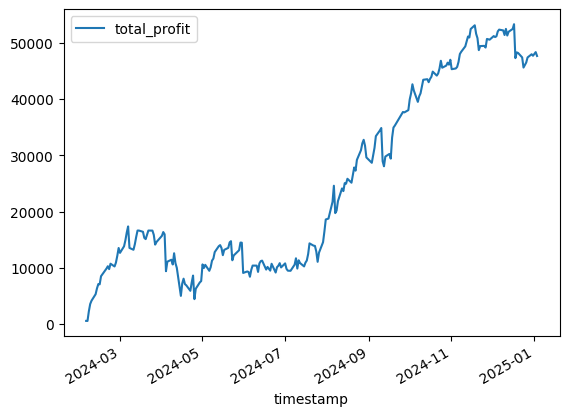

In [ ]:
profit_df, _ = do_simulation(
    datetime(2024, 2, 5),
    datetime(2025, 1, 6),
    asset,
    asset_data_service,
    options_data_service,
    opening_strategy_iron_condor_specific_minute_idx(60),
    closing_strategy_last_n(30),
)

profit_df.plot()

<Axes: xlabel='timestamp'>

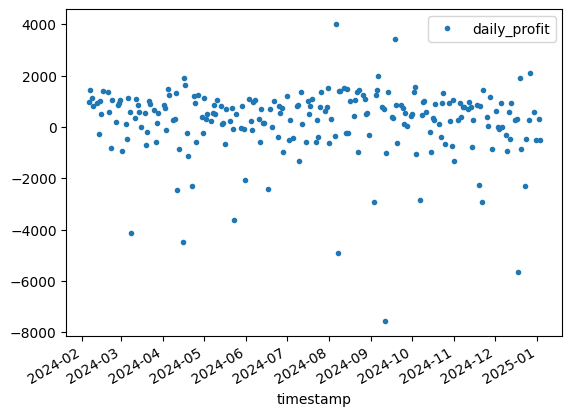

In [14]:
diff_df = profit_df.diff().rename(columns={"total_profit": "daily_profit"})
diff_df.plot(style='.')

Then a stop loss of around $2k sound like a good idea maybe?

100%|██████████| 237/237 [02:42<00:00,  1.46it/s]


Skipped 2 days due to incomplete data.


<Axes: xlabel='timestamp'>

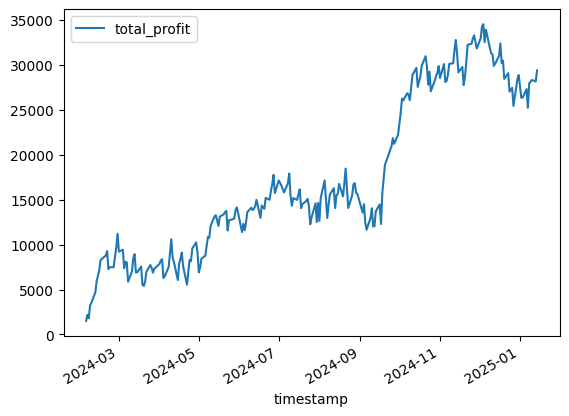

In [ ]:
profit_df, _ = do_simulation(
    datetime(2024, 2, 5),
    datetime(2025, 1, 15),
    asset,
    asset_data_service,
    options_data_service,
    opening_strategy_iron_condor_specific_minute_idx(2),
    closing_strategy_stoploss_or_last_n(2000, 30),
)

profit_df.plot()

<Axes: xlabel='timestamp'>

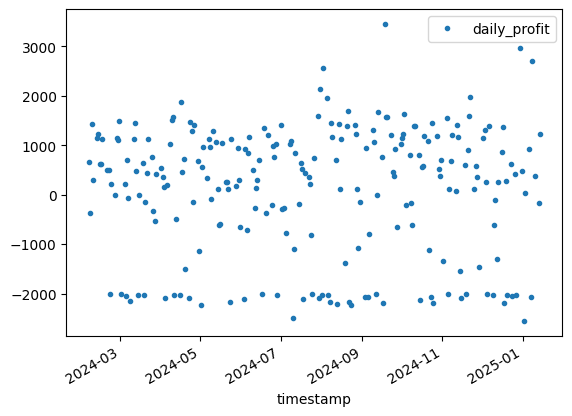

In [7]:
diff_df = profit_df.dropna().diff().rename(columns={"total_profit": "daily_profit"})
diff_df.plot(style='.')

In [8]:
f"Winning rate: {diff_df[diff_df['daily_profit'] > 0].shape[0] / diff_df.shape[0]:.2%}"

'Winning rate: 63.71%'

Some potential P&L analysis based on daily position movement

In [4]:
EXLUDE_LAST_N = 30

In [5]:
import matplotlib.pyplot as plt

In [6]:
daily_movements = daily_potential_pnl(
    datetime(2024, 2, 5),
    datetime(2025, 1, 15),
    asset,
    asset_data_service,
    options_data_service,
    opening_strategy_iron_condor_specific_minute_idx(2),
)

100%|██████████| 237/237 [03:35<00:00,  1.10it/s]

Skipped 2 days due to incomplete data. (inserted np.nan for them)


In [7]:
daily_movements = [movement for movement in daily_movements if np.isnan(movement).all() == False]
len(daily_movements)

235

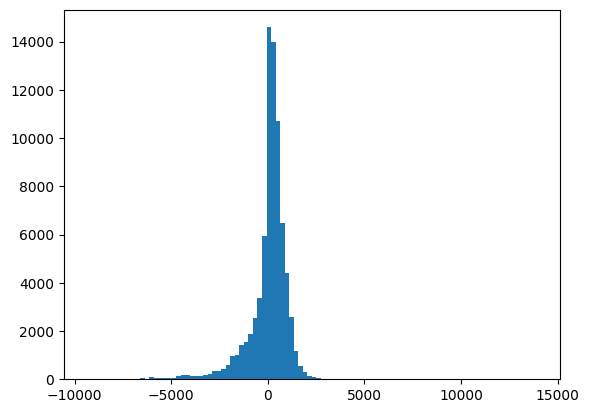

In [8]:
# quick histogram
all_values = [v for daily_values in daily_movements for v in daily_values[:-EXLUDE_LAST_N]]
plt.hist(all_values, bins=100)
plt.show()


<Axes: >

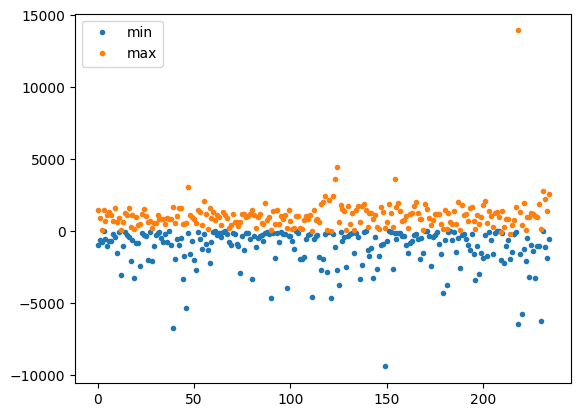

In [9]:
# daily min-max values

daily_min_max = [(min(daily_values[:-EXLUDE_LAST_N]), max(daily_values[:-EXLUDE_LAST_N])) for daily_values in daily_movements]
daily_min_max_df = pd.DataFrame(daily_min_max, columns=["min", "max"])

daily_min_max_df.plot(style='.')

In [10]:
n_days = daily_min_max_df.shape[0]

In [11]:
profit_categories = [2000, 1750, 1500, 1250, 1000, 800, 750, 500, 400, 300, 250]
loss_categories = [-250, -300, -400, -500, -750, -800, -1000, -1250, -1500, -1750, -2000]

profit_ratios = {
    cat: sum(
        1 if (daily_movement[:-EXLUDE_LAST_N] >= cat).any() else 0
        for daily_movement in daily_movements
    ) / n_days
    for cat in profit_categories
}

loss_ratios = {
    cat: sum(
        1 if (daily_movement[:-EXLUDE_LAST_N] <= cat).any() else 0
        for daily_movement in daily_movements
    ) / n_days
    for cat in loss_categories
}

profit_ratios, loss_ratios

({2000: 0.06382978723404255,
  1750: 0.12340425531914893,
  1500: 0.19148936170212766,
  1250: 0.33191489361702126,
  1000: 0.502127659574468,
  800: 0.6297872340425532,
  750: 0.6425531914893617,
  500: 0.7872340425531915,
  400: 0.8382978723404255,
  300: 0.8553191489361702,
  250: 0.8723404255319149},
 {-250: 0.7191489361702128,
  -300: 0.676595744680851,
  -400: 0.625531914893617,
  -500: 0.5914893617021276,
  -750: 0.46382978723404256,
  -800: 0.44680851063829785,
  -1000: 0.3872340425531915,
  -1250: 0.32340425531914896,
  -1500: 0.2851063829787234,
  -1750: 0.23404255319148937,
  -2000: 0.17872340425531916})

In [12]:
# profit vs loss matrix

profit_loss_matrix = pd.DataFrame(
    {
        profit_cat: [
            sum(
                1 if closing_strategy_limit_or_stoploss_or_last_n(profit_cat, -loss_cat, EXLUDE_LAST_N)(daily_movement) > 0 else 0
                for daily_movement in daily_movements
            ) / n_days
            for loss_cat in loss_categories
        ]
        for profit_cat in profit_categories
    },
    index=loss_categories
)

profit_loss_matrix

,2000,1750,1500,1250,1000,800,750,500,400,300,250
-250,0.280851,0.280851,0.280851,0.293617,0.314894,0.365957,0.370213,0.459574,0.519149,0.557447,0.578723
-300,0.323404,0.323404,0.323404,0.336170,0.361702,0.412766,0.417021,0.502128,0.557447,0.604255,0.625532
-400,0.370213,0.370213,0.370213,0.382979,0.404255,0.455319,0.459574,0.557447,0.617021,0.659574,0.680851
-500,0.395745,0.395745,0.395745,0.408511,0.425532,0.485106,0.489362,0.587234,0.642553,0.689362,0.714894
-750,0.485106,0.485106,0.485106,0.493617,0.519149,0.565957,0.570213,0.642553,0.706383,0.744681,0.765957
-800,0.485106,0.485106,0.485106,0.493617,0.519149,0.565957,0.570213,0.642553,0.706383,0.748936,0.770213
-1000,0.536170,0.536170,0.536170,0.544681,0.565957,0.608511,0.612766,0.680851,0.740426,0.774468,0.795745
-1250,0.578723,0.578723,0.582979,0.595745,0.617021,0.659574,0.663830,0.727660,0.774468,0.800000,0.821277
-1500,0.600000,0.600000,0.600000,0.612766,0.629787,0.672340,0.672340,0.744681,0.791489,0.812766,0.829787
-1750,0.617021,0.617021,0.617021,0.625532,0.642553,0.685106,0.685106,0.761702,0.804255,0.825532,0.842553


<Axes: >

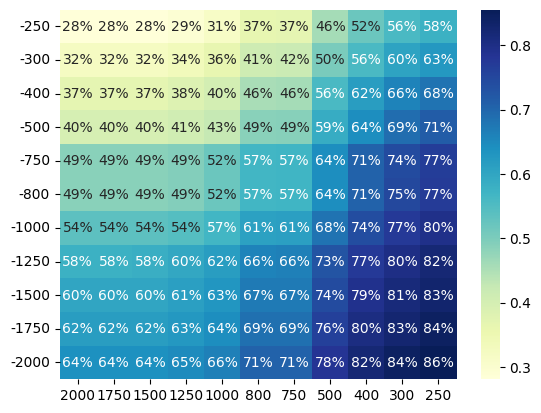

In [13]:
import seaborn as sns

# win rates

sns.heatmap(profit_loss_matrix, annot=True, fmt=".0%", cmap="YlGnBu")

In [15]:
# profitable win rates according to Kelly criterion

kelly_profit_loss_matrix = pd.DataFrame(
    {
        profit_cat: [
            1 - abs(profit_cat / (profit_cat - loss_cat))
            for loss_cat in loss_categories
        ]
        for profit_cat in profit_categories
    },
    index=loss_categories
)

kelly_profit_loss_matrix

,2000,1750,1500,1250,1000,800,750,500,400,300,250
-250,0.111111,0.125000,0.142857,0.166667,0.200000,0.238095,0.250000,0.333333,0.384615,0.454545,0.500000
-300,0.130435,0.146341,0.166667,0.193548,0.230769,0.272727,0.285714,0.375000,0.428571,0.500000,0.545455
-400,0.166667,0.186047,0.210526,0.242424,0.285714,0.333333,0.347826,0.444444,0.500000,0.571429,0.615385
-500,0.200000,0.222222,0.250000,0.285714,0.333333,0.384615,0.400000,0.500000,0.555556,0.625000,0.666667
-750,0.272727,0.300000,0.333333,0.375000,0.428571,0.483871,0.500000,0.600000,0.652174,0.714286,0.750000
-800,0.285714,0.313725,0.347826,0.390244,0.444444,0.500000,0.516129,0.615385,0.666667,0.727273,0.761905
-1000,0.333333,0.363636,0.400000,0.444444,0.500000,0.555556,0.571429,0.666667,0.714286,0.769231,0.800000
-1250,0.384615,0.416667,0.454545,0.500000,0.555556,0.609756,0.625000,0.714286,0.757576,0.806452,0.833333
-1500,0.428571,0.461538,0.500000,0.545455,0.600000,0.652174,0.666667,0.750000,0.789474,0.833333,0.857143
-1750,0.466667,0.500000,0.538462,0.583333,0.636364,0.686275,0.700000,0.777778,0.813953,0.853659,0.875000


<Axes: >

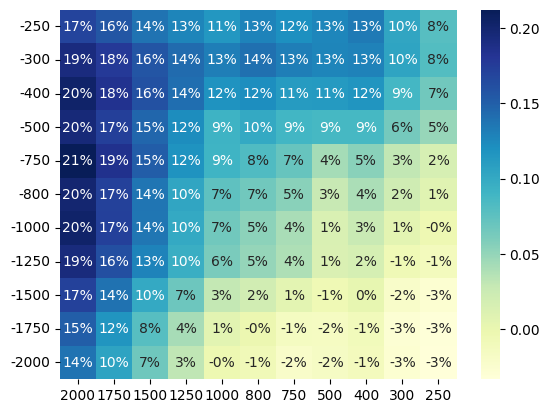

In [18]:
# difference between win rates and Kelly criterion

diff_profit_loss_matrix = profit_loss_matrix - kelly_profit_loss_matrix

sns.heatmap(diff_profit_loss_matrix, annot=True, fmt=".0%", cmap="YlGnBu")

<Axes: >

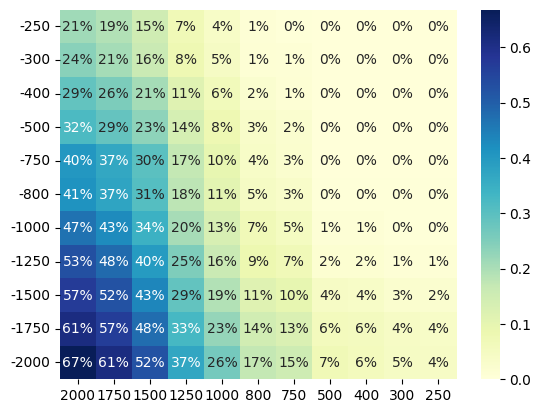

In [19]:
not_reaching_limit_or_stoploss_df = pd.DataFrame(
    {
        profit_cat: [
            sum(
                1 if ((daily_movement >= loss_cat).all() & (daily_movement <= profit_cat).all()) else 0
                for daily_movement in daily_movements
            ) / n_days
            for loss_cat in loss_categories
        ]
        for profit_cat in profit_categories
    },
    index=loss_categories
)

sns.heatmap(not_reaching_limit_or_stoploss_df, annot=True, fmt=".0%", cmap="YlGnBu")

<Axes: >

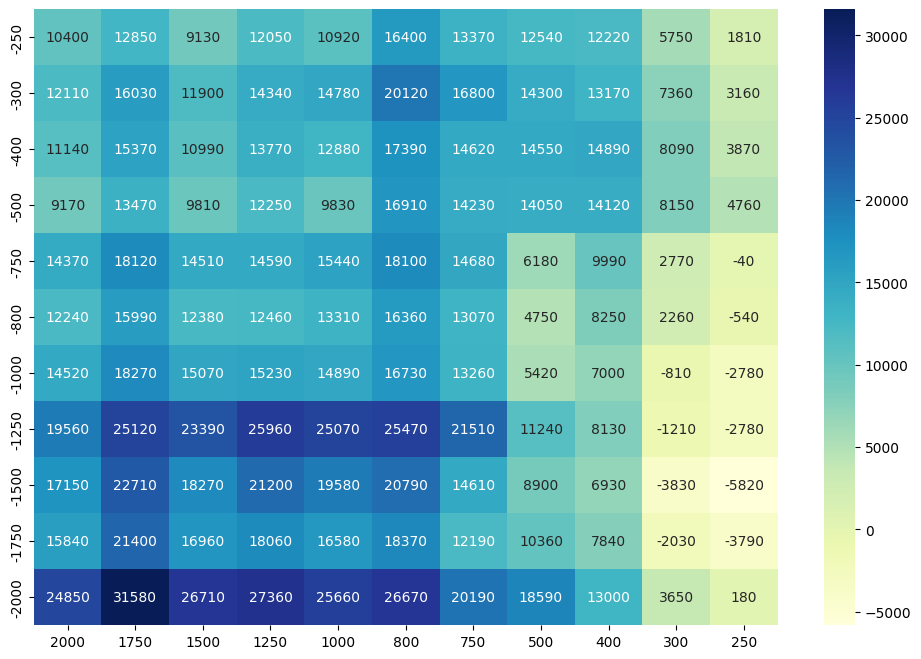

In [22]:
# total profit

total_profit_matrix = pd.DataFrame(
    {
        profit_cat: [
            sum(
                closing_strategy_limit_or_stoploss_or_last_n(profit_cat, -loss_cat, EXLUDE_LAST_N)(daily_movement)
                for daily_movement in daily_movements
            )
            for loss_cat in loss_categories
        ]
        for profit_cat in profit_categories
    },
    index=loss_categories
)

plt.figure(figsize=(12, 8))
sns.heatmap(total_profit_matrix, annot=True, fmt=".0f", cmap="YlGnBu")